# Python Class: NetworkX, Epidemics and Reporting Skills

This notebook serves as hand out material for a class delivered at the course in [Social and Economic Networks](http://didattica.unibocconi.it/ts/tsn_anteprima.php?cod_ins=20462&anno=2020&IdPag=6203) at [Bocconi University](https://www.unibocconi.eu/), taught by Professor [Fernando Vega-Redondo](http://didattica.unibocconi.eu/mypage/index.php?IdUte=166941&idr=21575&lingua=eng).
The TA of the course is [Melika Liporace](https://melikaliporace.github.io/).
I have been invited to deliver said class in the Spring 2020 iteration of the course.

This notebook has several objectives.

- Introduce readers to the [NetworkX](https://networkx.github.io/) package for Python.
- Show one potential attitude towards professional coding, with an application on an epidemics model.
    - Give a basic understanding of [Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling), as cornerstone of Monte Carlo Methods.
    - Introduce readers to the use of classes in Python.
- Show one potential way of professionally presenting results, with an application on synthetically generated data.
    - Introduce readers to some advanced plotting techniques with [Matplotlib](https://matplotlib.org/).
    - Introduce readers to some basic data science techniques with [pandas](https://pandas.pydata.org/).

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Do not run the following if not on Jupyter Notebooks!
# It allows graphics on the notebook to be rendered as SVG figures
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

## [NetworkX](https://networkx.github.io/)

[Networkx](https://networkx.github.io/) is a Python package that allows to easily deal with and manipulate networks of different kinds.
The main (and only?) reference for this section is the [official documentation of Networkx](https://networkx.github.io/documentation/stable/).
In particular, the [official tutorial](https://networkx.github.io/documentation/stable/tutorial.html) is especially useful for those who start from scratch.
Because the documentation is very well written, I will not write how to use the package.
However, if you really want something written by me, you can check out my other notebook, [Introduction to Python](./intro_to_python.ipynb): it has a [special section about NetworkX](./intro_to_python.ipynb#NetworkX).

The code that follows in this notebook assumes basic familiarity with NetworkX.
In particular, it assumes knowledge of the fact that nodes can be given arbitrary attributes, such as their state.

## A SIRS-like model of  contagion

<sup><i>If you are reading from the future, it's early 2020 and we're facing <a href="https://en.wikipedia.org/wiki/Coronavirus_disease_2019">COVID-19</a> as a global challenge.</i></sup>

We are going to create a spin of the SIRS model of contagion.
By this, we mean a network where nodes can be in the usual 3 states (Susceptible, Infected and Removed), but an infected person can transition to either being susceptible again, or to being removed.
In addition, we consider the duration of the infection to be random for each person.
That is, an infected person becomes susceptible again, stays infected or becomes removed with transition probabilities $p_{I,S}$, $p_{I,I}$ and $p_{I,R} = 1 - p_{I,S} + p_{I,I}$ respectively.
A susceptible person that has no infected neighbor remains susceptible.
A susceptible person that has at least one infected neighbor becomes infected with probability $p_{S,I}$ and remains susceptible with probability $p_{S,S} = 1 - p_{S,I}$.
A removed person remains removed forever.

To summarize the transition probabilities, we can use the following conditional transition matrices.

\begin{align*}
    \pi | \text{no infected neighbor} &=
        \begin{bmatrix}
            1       & 0       & 0       \\
            p_{I,S} & p_{I,I} & p_{I,R} \\
            p_{R,S} & 0       & p_{R,R}
        \end{bmatrix}
    &
    \pi | \text{infected neighbor} &=
        \begin{bmatrix}
            p_{S,S} & p_{S,I} & 0       \\
            p_{I,S} & p_{I,I} & p_{I,R} \\
            p_{R,S} & 0       & p_{R,R}
        \end{bmatrix}
\end{align*}

The goals we are after are the following:

1. Simulating the epidemics model.
1. Analyzing the spread of the disease, based on summary statistics.
1. Providing an illustration of the dynamics.
1. Doing all of the above for different networks and parametrizations.

### From theory to code

When we are given a model, it is not obvious to see where to start.
Coming up with code from scratch is a skill that needs to be acquired through practice.
However, there are few hints that make the process easier:

- Write functions, not scripts: this allows us to focus on small bits of code and helps ensure we are getting it right. The smaller the function, the easier it is to check that it does the right thing.
- Make functions work together: write functions such that the output of one function becomes the input of another function. Alternatively, wecan write functions that work in a nested fashion. This allows us to simplify coding by focusing on one task at a time. If we get one function right, we know we do not need to look into that to figure out where the mistake is.
- Start from the smallest task and work our way up to the bigger picture. This makes us focus on more difficult things first, making the whole effort look a lot more reachable.

To put these hints in practice, we can proceed in the following way.

1. First, we focus on the "innermost" step of our code. We need to be able to draw random states based on a known probability distribution function. We will call this function `draw_discrete_rv`.
1. Next, we focus on an individual node. We need to decide how its state changes depending on the transition probabilities and on the state of its neighbors. Say we write a function that does this and we call it `change_state`.
2. Then, we apply the function `change_state` to all nodes in the network. In doing so, we are applying the transition from one state of the network ("current") to another state ("next"). Let us write a function about this and call it `network_transition`.
3. Finally, given `network_transition`, we can consider a given network, a given number of periods to simulate and given transition probabilities to simulate the model. At every period, we just need to apply the function `network_transition` a given number of times and keep track of the history of states. We write yet another function only for this, and we call it `simulate_epidemy`.

When we have those three functions, we can consider creating different networks and different parametrizations and then analyze the results.

#### Step 1: `draw_discrete_rv`

This is the core of the simulation.
We need to draw states from a discrete random variable, given some Probability Distribution Function (pdf).
In particular, the function needs to draw a new random state, `'S'`, `'I'` or `'R'`, based on the transition probabilities.

We can resort to the [Inverse Transform Sampling method](https://en.wikipedia.org/wiki/Inverse_transform_sampling), which is an important technique at the basis of Monte Carlo methods.
The theorem supporting the method is the following.

> Let $F$ be a (right-)continuous cumulative distribution function, and let $F^{−1}$ be its inverse function.
> Then, if $u \sim U_{[0,1]}$ is a uniform random variable, $F^{-1}(u)$ has $F$ as its CDF.

Note that the statement holds for _any_ CDF whose functional form $F$ is known.

For concreteness, consider the example of drawing an integer $x \in \{1, 2, 3\}$.
Suppose that the Probability Distribution Function is such that $Pr(x=1) = p_1$, $Pr(x=2) = p_2$ and $Pr(x=3) = p_3$ (obviously, $p_1 + p_2 + p_3 = 1$).
The CDF associated to this PDF is

\begin{align*}
    F(x) &= 
        \begin{cases}
            0 & x \in (-\infty, 1) \\
            p_1 & x \in [1, 2) \\
            p_1 + p_2 & x \in [2, 3) \\
            p_1 + p_2 + p_3 & x \in [3, +\infty)
        \end{cases}
\end{align*}

Now suppose we draw a number $u \sim U_{[0,1]}$.
By definition of uniform distribution, we have 

- $0 \leq u < p_1$ with probability $p_1$;
- $p_1 \leq u < p_1 + p_2$ with probability $p_2$; and
- $p_1 + p_2 \leq u \leq 1$ with probability $p_3$.

Therefore, if we have
- $u \in [0, p_1)$, we can say we drew the value $1$;
- $u \in [p_1, p_1 + p_2)$, we can say we drew the value $2$; and
- $u \in [p_1 + p_2, 1]$, we can say we drew the value $3$.

The following figure provides a graphical illustration of what we just said.

![Inverse Transform Sampling](./img/inverse_transform_sampling.png)

In the figure, the blue line corresponds to the CDF of some random variable $X$.
The figure shows that drawing $u_1$ (happens with prob. $p_1$) amounts to drawing the integer $1$; drawing $u_2$ (happens with prob. $p_2$) amounts to drawing the integer $2$; drawing $u_3$ (happens with prob. $p_3$) amounts to drawing the integer $3$.

Because of the Inverse Transform Sampling method, and going back to our epidemics model, consider the example of drawing states `'S'` or `'I'` for a susceptible agent in the network who has at least one infected neighbor.
We can write the following code to draw the state.

```python
u = np.random.uniform()
if 0 <= u < p_ss:
    state = 'S'
elif p_ss <= u < 1:  # 1 = p_ss + p_si
    state = 'I'
```

However, let us try to write a slightly more general function.
Suppose that we do not know the number of possible states ex-ante.
Suppose we only have a vector of probabilities (the PDF), where the number of elements can vary.
In this case, we need to cumulate the PDF in order to obtain the CDF.
Moreover, let us write the function such that the support of the PDF does not need to be a set of integers, but can even be strings or other objects.
In this setting, the less straightforward step is the one of figuring out where the uniform draw $u$ stands relative to the CDF.
It turns out, the CDF is an ordered vector with non-decreasing entries.
Therefore, we can use `numpy.searchsorted`.
To see how it works, consider the following example.
Say we have the following vector, where elements are sorted in increasing order:
\begin{align*}
    x = [x_0, x_1, x_2, x_3, x_4]
\end{align*}
Suppose we draw $u$ such that $x_1 < u < x_2$.
The function `numpy.searchsorted` answers the following question: _"in what position would $u$ be if we were to insert it into the vector $x$ while keeping the ordering?"_
Therefore, we need to imagine a vector $\hat{x}$ such that
\begin{align*}
    \hat{x} = [x_0, x_1, u, x_2, x_3, x_4]
\end{align*}
In $\hat{x}$, $u$ is in position 2 (we are counting from zero with Python).
Therefore, `numpy.searchsorted(x, u)` returns `2` in this example.

With all of this in mind, we can write the function.

In [3]:
def draw_discrete_rv(pdf, support=None):
    
    if support is None:
        support = list(range(pdf.size))
        
    cdf = np.cumsum(pdf)
    u = np.random.uniform()
    index = np.searchsorted(cdf, u)
    
    return support[index]

#### Step 2: `change_state`

In this function, we consider an individual node and we change its state.
In order to do so, we need the following ingredients.

- We need to know the identity of the node under consideration.
- We need to find its neighbors, which requires knowledge of the network.
- We need to know if any of its neighbors is infected, which requires knowledge of the state of the network.
- We need to know the transition probabilities.

Given that we wrote `draw_discrete_rv`, the most complicated part here is to choose the adequate PDF given the current state of the node.
This means that we need to consider the current state of the node, together with observing if any neighbor is infected.
Distinguishing the possible current states, and whether the node has infected neighbors, can easily be done with `if..elif..else` statements.

These ingredients need to be input parameters for the function.

The main problem here is to keep track of states.
While NetworkX allows for "states" to be associated to nodes, we will take a shortcut.
The state of the network can be represented as an external object, relative to the network.
Here, we choose to represent the state of the network as an ordered `list`: each element's _position_ corresponds to the identity of the node, while the element itself will be the state (so, it has to be a value between `'S'`, `'I'` and `'R'`).

In [4]:
def change_state(i, state, network, p_ss, p_si, p_sr, p_is, p_ii, p_ir, p_rs, p_ri, p_rr):
    
    neighbors = network.neighbors(i)
    infected_neighbor = any([state[n] == 'I' for n in neighbors])
    pdf_if_S = np.array([p_ss, p_si, p_sr])
    pdf_if_I = np.array([p_is, p_ii, p_ir])
    pdf_if_R = np.array([p_rs, p_ri, p_rr])
    state_labels = ['S', 'I', 'R']

    if state[i] == 'S':            # if an agent is currently susceptible...
        if not infected_neighbor:  # ...if agent has no infected neighbor...
            new_state = 'S'        # ...the agent remains susceptible
        else:                      # ...if agent has an infected neighbor...
            new_state = draw_discrete_rv(pdf_if_S, state_labels)
    
    elif state[i] == 'I':  # if an agent is currently infected...
        new_state = draw_discrete_rv(pdf_if_I, state_labels)

    elif state[i] == 'R':  # if agent is removed (either became dead or immune)...
        new_state = draw_discrete_rv(pdf_if_R, state_labels)
    
    else:
        raise ValueError('Unrecognized node state: {}'.format(state))
    
    return new_state

#### Step 3: `network_transition`

In this function, we take for granted that `change_state` works.
In particular, `change_state` considers an individual agent and appropriately draws a new state.
In order to do this for all nodes, we need to "wrap" the function we wrote in a `for` loop.

What ingredients do we need?

- We need to know the network, so that we have knowledge of how many nodes we have and how many neighbors each node has.
- We need to know the state of the network, so that we know who is susceptible, who is infected and who is removed.
- We need to know the transition probabilities, because `change_state` requires them.

As mentioned, all we need to do is to wrap `change_state` in an adequate loop.
The loop has to go across all nodes in the network.
We can create the whole `list` of new states using a _list comprehension_.
This is a technique in Python that allows us to construct a list out of a `for` loop in one line.

Let us assume for now that the transition probabilities are known, but let us "pack" them conveniently into a `dict`.
To illustrate how this can happen, consider having the following dictionary.

```python
keyword_args = {
    'key_a': value_a,
    'key_b': value_b,
    'key_c': value_c
}
```

We can pass this dictionary as an input argument, preceded by a double asterisk (`**`).
This technique in Python is called "unpacking".
In a nutshell, the line

```python
some_function(**keyword_args)
```

is equivalent to 

```python
some_function(key_a=value_a, key_b=value_b, key_c=value_c)
```

With this, we can write the function we need.

In [5]:
def network_transition(network, state, pi):
    
    n = network.number_of_nodes()    
    new_state = [change_state(node, state, network, **pi) for node in range(n)]
    
    return new_state

#### Step 4: `simulate_epidemy`

Now we are ready to code the last function we need to simulate the epidemics in a network.

What do we need to do this?

- We need to know the network.
- We need to know the transition probabilities (again, packed into a dictionary).
- We need to know for how many periods we want to simulate the epidemics.

Once we have these ingredients, and given that we have the function `network_transition`, we just need to wrap (again) that function in a `for` loop.
However, while `network_transition` was assuming the current state of the network was known, here we need to define the initial condition of the simulation.
That is, we need to set the state from which everything starts.
Additionally, we want to keep track of the history of states the network goes through.

First, we need to create the initial condition.
This will be represented by a `list` that has as many elements as the number of nodes in the network.
Before, we assumed that the index of each element is the identity of the node, while the element itself is the state.
We need to be consistent with this.

We want to start from a situation where everybody is susceptible, except for one node that gets infected for exogenous reasons.
We do not care about the identity of the "patient zero" in this exercise, so we are just going to draw a random integer from a discrete uniform distribution over the support $\{0, 1, ..., n-1\}$, where $n$ is the number of nodes in the network.
We can create the initial state with a list comprehension, where each element of the list is `'S'`.
Then, we randomly choose a node to be infected (`'I'`).

As we want to keep track of the history of states, we create a `list` that does this.
The first element of such list is the initial condition of the network.
The second element will be the state of the network after the first period.
The third element will be the state of the network after the second period, and so on.

In [6]:
def simulate_epidemy(t, network, pi):
    
    n = network.number_of_nodes()
    initial_state = ['S' for i in range(n)]

    patient_zero = np.random.randint(n)  # an integer from uniform distribution
    initial_state[patient_zero] = 'I'
    state_history = [initial_state]
    
    for _ in range(t):
        current_state = state_history[-1]
        new_state = network_transition(network, current_state, pi)
        state_history.append(new_state)
        
    return state_history

We are now ready to simulate the model.
All we need to do is

- Come up with a network; and
- Parametrize the problem.

However, before we do so, let us go through some ways we can present our results.

## Presenting results

You are given problem sets and some exercises involve using Python to simulate certain situations.
The questions that arises in this context is: _how can we present our results?_

When we write code, it is common and normal to have "messy" output: figures everywhere, text output flowing over and over again, and no eye-candy in how things are displayed.
This is normal when first jotting down some code, but at some point you need to wrap your results in a nice, convincing package.

Presenting results neatly is a valuable skill.
Employers ask for these skills all the time.
People listening to you may not care about how you did something, they want the so-called "elevator pitch".
This is also relevant in Academia: engaging your audience with clean and clear results is the only way to convince them.
As a side effect, your TA will be happier, too 😄

There are two tools that come in handy: [pandas](https://pandas.pydata.org/) and [Matplotlib](https://matplotlib.org/).
The first one is the Swiss-Army knife of data science.
It allows us to easily treat data and compute summary statistics.
The second package allows for static plotting.
This means that plots are generated as static images, and miss interactivity.

<sup>If you are interested in interactive plots, check out <a href="https://plot.ly/">plot.ly</a> and <a href="https://bokeh.org/">bokeh</a>.</sup>

### Managing data

We can manage the results using pandas.
Essentially, pandas defines a DataFrame, which is a table of data.
Each column represents a variable and each row represents an observation.
However, this is not the only way.

There is an important concept in data science, and more specifically data management.
It is the distinction between _wide_ and _long_ data.
To understand the difference, let us use an example.

In [7]:
wide_table = pd.DataFrame({'name':   ['John', 'Jane', 'Joe'],
                           'age':    [16,     27,     23],
                           'height': [160,    182,    176],
                           'weight': [67,     78,     85]})
wide_table

,name,age,height,weight
0,John,16,160,67
1,Jane,27,182,78
2,Joe,23,176,85


In [8]:
long_table = wide_table.melt(id_vars=['name'], var_name='attribute')
long_table

,name,attribute,value
0,John,age,16
1,Jane,age,27
2,Joe,age,23
3,John,height,160
4,Jane,height,182
5,Joe,height,176
6,John,weight,67
7,Jane,weight,78
8,Joe,weight,85


As you can see, the two dataframes represent the exact same data in different formats.
In particular, the variable _names_ in the wide format have been mapped into variable _values_ in the long data.
The other conceptual difference is in defining what a variable is.
While wide data make it much easier to identify the statistical unit, long data make it easier to distinguish variables by their type.
In the example above, `name` and `attribute` are categorical variables, while `value` is a numeric variable.

Why would we need to use data in long format?
Well, long formats are much easier to work with, and sometimes are the only choice if we integrate Python with other systems (e.g., [SQL](https://en.wikipedia.org/wiki/SQL)).
Importantly, the [split-apply-combine paradigm](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) of data analysis only works with long formats.
Suppose we wanted to create averages by columns, but only for those people that are in their twenties.
With wide tables, we need to filter on one variable, then apply the average for each other variable.
With long tables, we need to filter on one variable, group by another and compute the average by group on yet another variable.
This might sound silly and unnecessary with the example above, but when your data grows in size and complexity, long formats are probably the only choice.
Moreover, this sort of operatations are characterized by more readable code when using long formats.

<sub>
If you are interested in these topics and their practical applications, as well as the rationale behind certain choices, I strongly recommend <a href="https://r4ds.had.co.nz/index.html"><i>R for Data Science</i></a>, by Garrett Grolemund and Hadley Wickham.
While the book is written around R (and not Python, nor pandas), it does an excellent job at explaining the basic philosophy behind data science methods and techniques.
Here we do not have the time or space to go through all of that, so I will simply proceed with a hands-on approach with our synthetic epidemics data.
</sub>

Back to our simulated epidemics.
We want to 

- plot the evolution over time of the number of cases, and
- obtain a table with long-run statistics about the epidemics.

The complication is that we have the network and a list of lists to represent the history of states.
We need to do some work to turn all of that into statistical data.
They way we go around this is the following.
First, a list of lists is nothing else than a matrix, where each "inner" list is a row, and the "outer" list collects the rows altogether.
Second, we can read such matrix into a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).
This will result in a data table where each row is a period and each column is an individual.
We may want to transpose this layout, so to be clear about the statistical unit of the synthetic experiment.
Then, we can convert this (wide) data into long format, so it is much easier to work with it later on.
To perform these tasks, we write a function, `simulation_to_dataframe`.

In [9]:
def simulation_to_dataframe(history, network):
    
    df1 = pd.DataFrame(history).transpose()  # row: node. column: period.
    df1['individual'] = df1.index
    df1 = df1.melt(id_vars=['individual'],
                   var_name='period',
                   value_name='state')
    df1.sort_values(by=['individual', 'period'], inplace=True)
    
    degrees = network.degree
    df2 = pd.DataFrame.from_dict(dict(degrees), orient='index')
    df2.reset_index(inplace=True)
    df2.rename(columns={'index': 'individual', 0: 'no_of_neighbors'},
               inplace=True)
    
    df = pd.merge(df1, df2, on='individual', how='left')
    
    return df

### Reporting, like a pro

First, let us plot the evolution of cases over time.
To do this, we write a function, `show_states_over_time`.
We are just interested in plotting numbers over time.
Given the data we have, we care about counting how many agents are in each state (`'S'`, `'I'`, `'R'`) for each period.
Therefore, we need to group by periond and count values (within each group).
This results in a [pandas.Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) object, which is like a single column in a DataFrame.
Since a Series does not allow us to go further, we need to convert it back to a DataFrame.
We can know [pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html) the data (transform it from long to wide), so that each row is a period and each column is a variable: the number of susceptible, infected and removed agents respectively.
We can rename the columns, so to have nice legends appearing by default in the plot.
Finally, we [plot](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html) the dataframe and add some graphic sugar, such as axes labels and a title.

In [10]:
def plot_states_over_time(data):
    """
    Plots epidemics data. This function does not return anything.

    Parameters
    ----------
    data : pandas.DataFrame
            A dataframe with at least the following columns: 'individual',
            'period' and 'state'. All columns are expected to contain
            categorical variables, but 'state' needs to contain only three
            admissible values: 'S', 'I' and 'R'.
    """

    df = data[['individual', 'period', 'state']]
    n = df.individual.nunique()
    
    counts_series = df.groupby(by='period').state.value_counts()
    percentages = pd.DataFrame(counts_series) / n * 100
    renamed = percentages.rename(columns={'state': 'cases'})
    counts = renamed.reset_index()
    states_over_time = counts.pivot(index='period',
                                    columns='state',
                                    values='cases')
    states_over_time.rename(columns={'S': 'Susceptible',
                                     'I': 'Infected',
                                     'R': 'Removed'}, inplace=True)
    states_over_time.fillna(value=0, inplace=True)

    states_over_time.plot()
    plt.grid(alpha=0.3)
    plt.xlabel(r'Periods from outbreak')
    plt.ylabel(r'Percentage of population (%)')
    plt.title(r'Evolution of cases over time')

Now let us turn to the table of long-run dynamics.
For this, we want to simulate the model a certain number of times and we want to know, in summary, what we can expect about the time series of the counts of susceptible, infected and removed people.
To do this, we need to keep in mind that the initial condition will affect the statistics.
Therefore, we should remove some observations at the beginning of the simulated sample in order to have estimates that do not depend on the initial condition.
The observations that are discarded are referred to as _burn-in_ observations: these are data points that have been produced while the algorithm produced while it was "warming up".

In [11]:
def long_run_outcome(t, network, pi, burn_in=50):
    
    n = network.number_of_nodes()
    simulation = simulate_epidemy(t, network, pi)
    data = simulation_to_dataframe(simulation, network)
    
    df = data[['individual', 'period', 'state']]
    counts_series = df.groupby(by='period').state.value_counts()
    counts_df = pd.DataFrame(counts_series) / n * 100
    renamed = counts_df.rename(columns={'state': 'cases'})
    counts = renamed.reset_index()
    states_over_time = counts.pivot(index='period',
                                    columns='state',
                                    values='cases')
    states_over_time.rename(columns={'S': 'Susceptible',
                                     'I': 'Infected',
                                     'R': 'Removed'}, inplace=True)
    states_over_time.fillna(value=0, inplace=True)
    
    states_over_time.reset_index(inplace=True)
    cropped_data = states_over_time[states_over_time.period > burn_in]
    
    des = cropped_data.describe()[['Susceptible', 'Infected', 'Removed']]
    description = des.loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    
    return description

## Run all the code

With all these functions, we are now ready to execute it.

First, we parametrize the model.
This means choosing numeric values for the transition probabilities and choosing a network structure.

In [12]:
# no. of periods to simulate
t = 150

# transition probabilities
transition_probs = {
    'p_ss': 0.05,
    'p_si': 0.95,
    'p_sr': 0.00,
    'p_is': 0.35,
    'p_ii': 0.60,
    'p_ir': 0.05,
    'p_rs': 0.30,
    'p_ri': 0.00,
    'p_rr': 0.70
}

# a small-world network
net = nx.binomial_tree(n=8)

Next, we just call the functions we wrote above.

In [13]:
state_history = simulate_epidemy(t, net, transition_probs)
database = simulation_to_dataframe(state_history, net)

Let us take a look at the database.

In [14]:
database

,individual,period,state,no_of_neighbors
0,0,0,S,8
1,0,1,S,8
2,0,2,S,8
3,0,3,S,8
4,0,4,I,8
...,...,...,...,...
38651,255,146,I,1
38652,255,147,S,1
38653,255,148,S,1
38654,255,149,I,1


Now let us plot the dynamics of states.

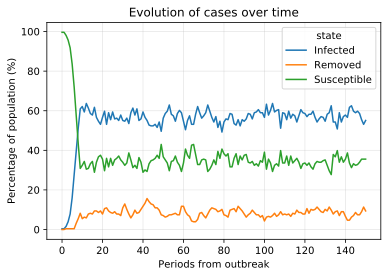

In [15]:
plot_states_over_time(database)

Finally, let us take a look at the long-run outcome of this epidemy.

In [16]:
long_run_outcome(t, net, transition_probs).round(decimals=2)

state,Susceptible,Infected,Removed
mean,34.38,56.21,9.40
std,2.96,3.07,1.79
min,26.56,49.61,5.08
25%,32.42,54.30,8.20
50%,33.98,56.25,9.38
75%,36.72,57.91,10.55
max,41.41,64.06,13.28


## What to do now?

There are a number of things we may wish to do with the machinery obtained so far.

1. We can simulate the epidemics for arbitrary networks.
   Given that we only wrote functions, we can easily reuse the code to change the network and/or parameters and see how the results change.

1. We could actually have used the package NetworkX to keep track of the states.
   In fact, NetworkX supports node attributes, where we could have done the following.

   ```python
   network = nx.cycle_graph(n)
   nx.set_node_attributes(network, 'S', 'state')
   ```

  This chunk of code sets all nodes in the network as susceptible.
  NetworkX has no idea of what we want to do with attributes, so think of that as simple labelling on top of nodes.
  Yet, we could have done this to keep track of the epidemy.
  If we did this, we would have kept track of the history as a sequence of graphs (a list of networks), as opposed to a sequence of states (a list of lists).
  
1. We could document all functions. Python allows for _docstrings_. These are comments, delimited by triple double-quotes (e.g., `"""This is a docstring"""`), that can span multiple lines. They are especially used to write what a function does and document what kind of inputs and outputs are involved.
  
1. We could enrich the reporting of long run outcomes.
   For example, we may want to know how many people are in each state, `'S'`, `'I'` and `'R'`, how many people switched multiple times from `'S'` to `'I'` to `'S'` before switching to `'R'` and what is the average number of periods people are not in the `'R'` state.

1. We can put all our code together in a `class`, so that we can reuse much more easily it anytime we need to simulate a SIRS-like model.
   An example on how to do this is below.

## Packaging all up in one `class`

Packaging code in one class just makes it easier to work with it.
Instead of passing input arguments around, we can just refer to known instance data using the `self` keyword.
While I will not discuss all details on how to write a class in Python, I write here an example of how we can define the `SIRS` class.
Notice that for most part, I copy-pasted the code written above.
The few changes almost only concern the input arguments of functions, which have been slimmed down in favor of referring to data in `self`.

In [17]:
class SIRS:

    def __init__(self, network, transition_probabilities):

        self.network = network
        self.pi = transition_probabilities

        self.n = network.number_of_nodes()
        self.degrees = pd.DataFrame.from_dict(network.degree)
        self.degrees.columns = ['node', 'degree']


    @staticmethod
    def _draw_discrete_rv(pdf, support=None):
        """
        This function draws a random state from a discrete random variable,
        given its probability distribution function. It implements the Inverse
        Transform Sampling method for any discrete random variable.

        Parameters
        ----------
        pdf : numpy.ndarray
              A vector array with the probabilities associated to each state.
        support : list (optional)
                  A list with as many elements as the number of elements of
                  'pdf'. It contains the labels for the state. These will be
                  returned according to the random draw. If this input is
                  omitted, then an integer from range(pdf.size) will be
                  returned.

        Returns
        -------
        state : int or one element of 'support'
        """

        if support is None:
            support = list(range(pdf.size))

        cdf = np.cumsum(pdf)
        u = np.random.uniform()
        index = np.searchsorted(cdf, u)

        return support[index]


    def _change_state(self, i, state):
        """
        Changes the state of the i-th node in a network based on the state of
        neighboring nodes.

        Parameters
        ----------
        i : int
             An integer indicating a node in the network
        state : list
                A list with as many elements as nodes in the network,
                containing the state of each node. Admissible elements are 'S',
                'I' and 'R'.

        Returns
        -------
        new_state : str
                    Either 'S', 'I' or 'R' based on the rules of the model.
        """

        neighbors = self.network.neighbors(i)
        infected_neighbor = any([state[n] == 'I' for n in neighbors])
        pdf_S = np.array([self.pi['p_ss'], self.pi['p_si'], self.pi['p_sr']])
        pdf_I = np.array([self.pi['p_is'], self.pi['p_ii'], self.pi['p_ir']])
        pdf_R = np.array([self.pi['p_rs'], self.pi['p_ri'], self.pi['p_rr']])
        state_labels = ['S', 'I', 'R']

        if state[i] == 'S':
            if not infected_neighbor:
                new_state = 'S'
            else:
                new_state = self._draw_discrete_rv(pdf_S, state_labels)

        elif state[i] == 'I':
            new_state = self._draw_discrete_rv(pdf_I, state_labels)

        elif state[i] == 'R':
            new_state = self._draw_discrete_rv(pdf_R, state_labels)

        else:
            raise ValueError("Unrecognized node state '{}'".format(state))

        return new_state


    def _network_transition(self, state):
        """
        Simulates the transition of the whole network from one period to the
        next.

        Parameters
        ----------
        state : list
                A list with as many elements as nodes in the network,
                containing the state of each node. Admissible elements are 'S',
                'I' and 'R'.

        Returns
        -------
        new_state : list
                    A list with as many elements as nodes in the network,
                    containing the state of each node.
        """

        new_state = [self._change_state(i, state) for i in range(self.n)]

        return new_state


    def _simulation_to_dataframe(self, history):
        """
        Transforms a simulated history of epidemics into a pandas.DataFrame in
        long format.

        Parameters
        ----------
        history : list (of lists)
                The history obtained from simulating an epidemy in a network.
        network : networkx.Graph
                An undirected network with no parallel links.

        Returns
        -------
        df : pandas.DataFrame
            A dataframe with three columns: 'individual', 'period' and 'state'.
        """

        df1 = pd.DataFrame(history).transpose()  # row: node. column: period.
        df1['individual'] = df1.index
        df1 = df1.melt(id_vars=['individual'],
                    var_name='period',
                    value_name='state')
        df1.sort_values(by=['individual', 'period'], inplace=True)

        degrees = self.network.degree
        df2 = pd.DataFrame.from_dict(dict(degrees), orient='index')
        df2.reset_index(inplace=True)
        df2.rename(columns={'index': 'individual', 0: 'no_of_neighbors'},
                inplace=True)

        df = pd.merge(df1, df2, on='individual', how='left')

        return df


    def simulate_epidemy(self, t):
        """
        Simulates the SIRS model for a given number of discrete periods and
        given a network structure. It is assumed that, at the beginning of
        time, all nodes are in state 'S' (susceptible) and one random node
        turns exogenously to state 'I' (infected).

        Parameters
        ----------
        t : int
            The number of discrete periods to simulate.

        Returns
        -------
        history : an ordered list of the state of the network at each simulated
                period. history[0] corresponds to input parameter 'network',
        """

        n = self.network.number_of_nodes()
        initial_state = ['S' for i in range(n)]

        patient_zero = np.random.randint(n)
        initial_state[patient_zero] = 'I'
        state_history = [initial_state]

        for _ in range(t):
            current_state = state_history[-1]
            new_state = self._network_transition(current_state)
            state_history.append(new_state)

        df = self._simulation_to_dataframe(state_history)
        return df
    
    
    def long_run_outcome(self, t=250, burn_in=50):
        """
        Provides summary statistics of the number of cases, by case, in the
        long run, after the outbreak. To generate the numbers, the model is
        simulated. Because the initial condition takes some periods to not
        matter anymore, this function will discard some initial periods. The
        reported numbers are percentages relative to the number of nodes in the
        network.
        
        Parameters
        ----------
        t : int (optional)
             Number of periods to simulate to obtain long-run statistics.
        burn_in : int (optional)
                  Number of periods to discard at the beginning, to prevent
                  over-reliance of the results from the initial condition.
                  
        Returns
        -------
        description : pandas.DataFrame
                      A table with columns ['Susceptible', 'Infected',
                      'Removed'] and rows ['mean', 'std', 'min', '25%', '50%',
                      '75%', 'max']
        """
        
        simulation = self.simulate_epidemy(t)
        
        df = simulation[['individual', 'period', 'state']]
        counts_series = df.groupby(by='period').state.value_counts()
        counts_df = pd.DataFrame(counts_series) / self.n * 100
        renamed = counts_df.rename(columns={'state': 'cases'})
        counts = renamed.reset_index()
        states_over_time = counts.pivot(index='period',
                                        columns='state',
                                        values='cases')
        states_over_time.rename(columns={'S': 'Susceptible',
                                         'I': 'Infected',
                                         'R': 'Removed'}, inplace=True)
        states_over_time.fillna(value=0, inplace=True)
        
        states_over_time.reset_index(inplace=True)
        cropped_data = states_over_time[states_over_time.period > burn_in]
        
        des = cropped_data.describe()[['Susceptible', 'Infected', 'Removed']]
        description = des.loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        
        return description

Let us reparametrize the problem.

In [18]:
n = 250  # no. nodes in the network
t = 150  # no. of periods to simulate

network = nx.watts_strogatz_graph(n, k=2, p=0.5)

transition_probabilities = {
    'p_ss': 0.05, 
    'p_si': 0.95, 
    'p_sr': 0.00, 
    'p_is': 0.25, 
    'p_ii': 0.70, 
    'p_ir': 0.05, 
    'p_rs': 0.30, 
    'p_ri': 0.00, 
    'p_rr': 0.70, 
}

Running the code in the `class` now becomes trivial.

In [19]:
epidemics_small_world = SIRS(network, transition_probabilities)
history_small_world = epidemics_small_world.simulate_epidemy(t)

In [20]:
epidemics_small_world.long_run_outcome()

state,Susceptible,Infected,Removed
mean,91.240000,7.506000,1.254000
std,1.097462,1.220908,0.657301
min,88.800000,4.000000,0.000000
25%,90.400000,6.800000,0.800000
50%,91.200000,7.600000,1.200000
75%,92.000000,8.400000,1.600000
max,95.200000,10.400000,3.200000


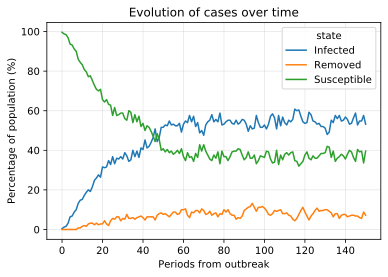

In [21]:
plot_states_over_time(history_small_world)